# Showcase Forecasting with Statistical Model vs Foundation Model

Traditionally, statistical models such as ARIMA (Auto-Regressive Integrated Moving Average) have been widely used because they are easy to understand, robust to data assumptions and based on strong theory. ARIMA requires model training specific to each dataset, involving parameter selection and tuning to optimise accuracy. This process can be time-consuming, but often produces reliable, interpretable results.

Foundation models such as MOIRAI, on the other hand, represent a new approach. Operating as zero-shot models, they do not require dataset-specific training or tuning, but instead use patterns learned from large, diverse data sources. This allows them to generalise to new forecasting tasks, making them highly versatile and scalable.

This comparison highlights the advantages and limitations of both approaches: MOIRAI as a zero-shot basic model that offers fast, plug-and-play forecasting, and Auto ARIMA as a traditional, statistical model that is often more tailored but requires dedicated tuning.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from gluonts.dataset.pandas import PandasDataset
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

import data_loader

## Dataset: Melbourne Pedestrian Counts

The dataset can be found [here](https://zenodo.org/records/4656626). This dataset contains hourly pedestrian counts captured from 66 sensors in Melbourne city starting from May 2009. We only take the first 10 time series for comparison.

In [2]:
# load dataset
data = data_loader.convert_tsf_to_dataframe('pedestrian_counts_dataset.tsf')
df = data[0]
df = pd.DataFrame(df['series_value'].tolist(), index=df['series_name']).T
df.dropna(axis=0, inplace=True) # drop nan rows
df = df.iloc[:, :10] # only take 10 time series
df.shape

(576, 10)

In [3]:
# add date
start_date = datetime(2009, 5, 1)
df['date'] = [start_date + timedelta(hours=i) for i in range(len(df))]

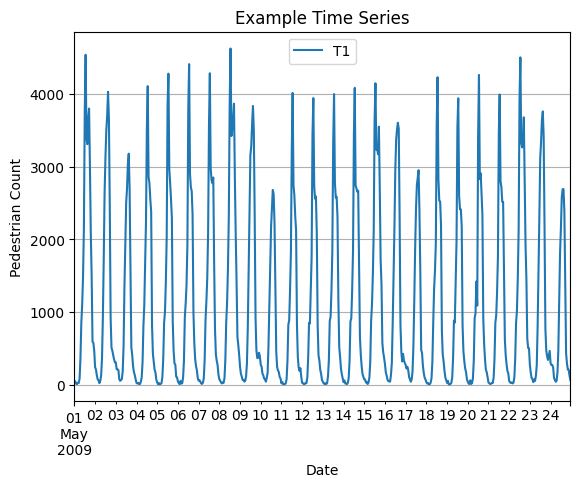

In [ ]:
# plot example time series T1
df.plot(y='T1', x='date', title="Example Time Series")
plt.xlabel("Date")
plt.ylabel("Pedestrian Count")
plt.grid(True)
plt.show()

In [ ]:
# train-test split
forecast_horizon = 24 # forecast for one day
train, test = df.iloc[:-forecast_horizon], df.iloc[-forecast_horizon:]
print(f'Number of data points after split: {len(train)} training - {len(test)} testing')

Number of data points after split: 552 training - 24 testing


## AutoARIMA

In [7]:
# bring dataset in statsforecast format
statsforecast_train_df = train.rename(columns={'date': 'ds'})
statsforecast_train_df = pd.melt(statsforecast_train_df, id_vars=['ds'], var_name='unique_id', value_name='y')
statsforecast_train_df.head()

,ds,unique_id,y
0,2009-05-01 00:00:00,T1,53.0
1,2009-05-01 01:00:00,T1,43.0
2,2009-05-01 02:00:00,T1,10.0
3,2009-05-01 03:00:00,T1,5.0
4,2009-05-01 04:00:00,T1,25.0


In [8]:
# prepare model
arima_predictor = StatsForecast(models = [AutoARIMA(season_length = 24)],freq = 'H')

# train
arima_predictor.fit(statsforecast_train_df)

StatsForecast(models=[AutoARIMA])

In [ ]:
# predict
arima_forecast_df = arima_predictor.predict(h=len(test))

## MOIRAI

In [10]:
# bring dataset in MOIRAI format (create GluonTS dataset)
gluonts_train_ds = PandasDataset.from_long_dataframe(statsforecast_train_df, item_id='unique_id', timestamp='ds', target='y')
gluonts_train_ds

PandasDataset<size=10, freq=H, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>

In [11]:
# prepare model
SIZE = "base" # model size: choose from {'small', 'base', 'large'}
CTX = 512 # context length: any positive integer
PSZ = 'auto' # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32 # batch size: any positive integer

model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-{SIZE}"), # load base model from huggingface
    prediction_length=forecast_horizon,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100, # MOIRAI supports probabilistic forecasting. num_samples is the number of times it samples the forecasting distribution
    target_dim=1, # 1 for univariate forecasts. Higher dimensions for multivariate forecasts
    feat_dynamic_real_dim=0, # for future covariates
    past_feat_dynamic_real_dim=0, # for past covariates
)

moirai_predictor = model.create_predictor(batch_size=BSZ)

In [12]:
# predict
forecasts = moirai_predictor.predict(gluonts_train_ds)
ds_it = iter(gluonts_train_ds)
moirai_forecast_values, item_id, date = [], [], []
for i, fc in enumerate(forecasts):
    moirai_forecast_values.extend(fc.median) # median gives better results for point forecasts than mean
    date.extend(fc.index.to_timestamp())
    item_id.extend([next(ds_it)['item_id']] * forecast_horizon) # match dataset ids with forecasts and repeat for the entire forecast horizon

## Comparison

For this comparison, we utilize the symmetric Mean Absolute Percentage Error (sMAPE). It is particularly useful in time series analysis as it provides a percentage-based measure of prediction error, allowing for easy interpretation and comparison across different datasets.

In [13]:
# merge test values with forecasts from both models
test = pd.melt(test, id_vars=['date'], var_name='unique_id', value_name='y')
test = pd.merge(test, arima_forecast_df, left_on=['unique_id', 'date'],
                right_on=['unique_id', 'ds'], how='left')
test.drop(columns=['ds'], inplace=True)
moirai_forecast_df = pd.DataFrame({'date': date,
                                   'unique_id': item_id,
                                   'MOIRAI': moirai_forecast_values})
test = pd.merge(test, moirai_forecast_df, left_on=['unique_id', 'date'],
                right_on=['unique_id', 'date'], how='left')

In [14]:
def cal_smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    denominator = np.where(denominator == 0, 1e-8, denominator)
    
    smape_value = np.mean(2 * np.abs(y_pred - y_true) / denominator) * 200
    return smape_value

In [15]:
# calculate sMAPE and combine results
results = []
for unique_id in test['unique_id'].unique():
    ts_data = test[test['unique_id'] == unique_id]
    smape_autoarima = cal_smape(ts_data['y'], ts_data['AutoARIMA'])
    smape_moirai = cal_smape(ts_data['y'], ts_data['MOIRAI'])
    results.append({
        'unique_id': unique_id,
        'sMAPE_AutoARIMA': smape_autoarima,
        'sMAPE_MOIRAI': smape_moirai
    })
smape_df = pd.DataFrame(results)
smape_df.describe()

,sMAPE_AutoARIMA,sMAPE_MOIRAI
count,10.000000,10.000000
mean,257.637536,147.204927
std,83.017336,73.374203
min,156.709238,69.716939
25%,193.537459,117.057261
50%,247.412856,129.678222
75%,314.471569,163.720365
max,408.223233,333.824007


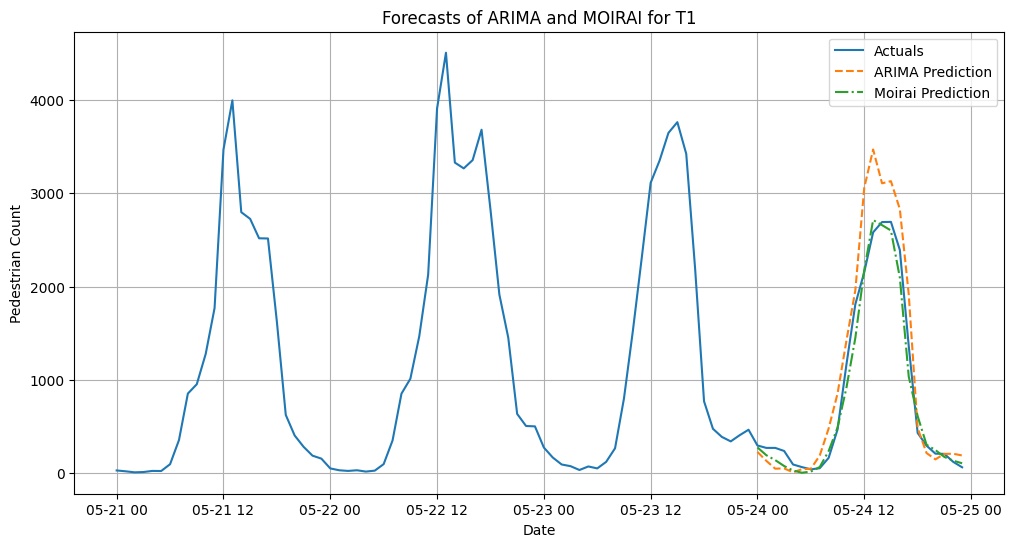

In [16]:
df_T1 = test[test['unique_id'] == 'T1']
plt.figure(figsize=(12, 6))
plt.plot(df['date'][-forecast_horizon*4:], df['T1'][-forecast_horizon*4:], label='Actuals')
plt.plot(df_T1['date'], df_T1['AutoARIMA'], label='ARIMA Prediction', linestyle='--')
plt.plot(df_T1['date'], df_T1['MOIRAI'], label='Moirai Prediction', linestyle='-.')
plt.xlabel('Date')
plt.ylabel("Pedestrian Count")
plt.title('Forecasts of ARIMA and MOIRAI for T1')
plt.legend()
plt.grid(True)
plt.show()

## Conclusion

Auto ARIMA takes 8 minutes to train and forecast these ten time series, while MOIRAI completes the task in just 15 seconds, illustrating the speed of foundation models. Importantly, MOIRAI outperforms Auto ARIMA in terms of accuracy, achieving an average sMAPE of 147% compared to Auto ARIMA's of 258%. In addition, MOIRAI operates as a probabilistic model, providing a distribution of possible outcomes, whereas Auto ARIMA only provides point forecasts with confidence intervals.

Both models can be implemented with minimal code. MOIRAI requires slightly more due to model configuration, but mainly uses default settings suitable for different time series. Notably, all the code was run on a CPU, and further improvements to MOIRAI could be realised with a GPU.

Furthermore, foundation models such as MOIRAI generally perform better on longer time series, while statistical models such as Auto ARIMA tend to excel on shorter time series. The main finding from this comparison is the ease of use of both models. A more comprehensive evaluation would require a larger dataset with different time series types for a fair comparison.